# Expectation-Maximisation For Gaussian Mixture Models
#### By Jonathan L. Moran (jo6155mo-s@student.lu.se)
From the EDAN95 - Applied Machine Learning course given at Lunds Tekniska Högskola (LTH) | Ht2 2019.

## Objectives
In this post you will
*    train a Gaussian NBC with the EM algorithm
*    compare the results you get to those of the k-Means clustering provided in SciKitLearn

## Background and Tools
The EM (Expectation-Maximisation) algorithm solves the problem of not being able to compute the Maximum Likelihood Estimates for unknown classes directly by iterating over the two steps until there is no significant change in Step 2 observable:
```
1.    Compute the expected outcome for each sample / sample given estimates for priors and distribution (essentially, the likelihoods for observing the sample assuming an estimated distribution)
```
```
2.    Compute the new estimates for your priors and distributions (in the case of a Gaussian NBC, new means and variances are needed) based on the estimated expected values for how much each sample belongs to the respective distribution.
```
You can find the algorithm stated explicitly as given in Murphy, "Machine Learning - A probabilistic perspective", pp. 352-353 [HERE](http://fileadmin.cs.lth.se/cs/Education/EDAN95/Handouts/EM-algo.pdf).

One special case of the EM algorithm is k-Means clustering, for which an implementation can be found in SciKitLearn.

## Implementation task
*1. Implement the EM-algorithm to find a Gaussian NBC for the `digits` dataset from SciKitLearn (you can of course also use the `MNIST_Light` set from Lab 5, but for initial tests the `digits` data set is more convienent, since it is smaller in various aspects). You may assume (conditional) indepdendence between the attributes, i.e., the covariances can be assumed to be simply the variances over each attribute. Split the data set in `70% training`, `30% test` data. If you experience problems due to the repreated multiplication of tiny values in likelihoods, it might help to normalise the data to values between `0.0` and `1.0` (i.e., simply divdie every pixel value with `16.0` in the `digits` data).*

### Collecting the dataset

Recall that the `digits` dataset consists of 1,797 samples. Each sample is an 8x8 image of a single handwritten digit from 0 to 9. Each sample therefore has 64 features, where each of the 64 features is a brightness value of a pixel in the image.

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
digits = load_digits()

In [ ]:
print('Shape of digits.images input array:', digits.images.shape)

Shape of digits.images input array: (1797, 8, 8)


In [ ]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

#### Visualising the data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

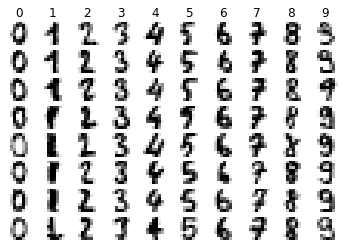

In [ ]:
# Display random sample of images per class
n_samples = 8
n_classes = 10
for cls in range(n_classes):
    idxs = np.where(digits.target == cls)[0]
    idxs = np.random.choice(idxs, n_samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(n_samples, n_classes, i * n_classes + cls + 1)
        plt.axis('off')
        plt.imshow(digits.images[idx], cmap=plt.cm.gray_r, interpolation='nearest')
        if i == 0:
            plt.title(str(cls))
plt.show()

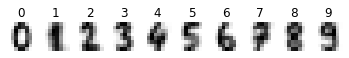

In [ ]:
# Display mean image of each class
cls_means = np.zeros(shape=(10,8,8))
for cls in range(n_classes):
    idxs = np.where(digits.target == cls)[0]
    cls_means[cls] = np.mean(digits.images[idxs], axis=0)
    plt.subplot(1, n_classes, cls + 1)
    plt.axis('off')
    plt.imshow(cls_means[cls], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(str(cls))
plt.show()

#### Splitting into training and test sets

In [ ]:
num_examples = len(digits.data)
print('Total examples:', num_examples)

Total examples: 1797


In [ ]:
split = int(0.7*num_examples)
print('Training set examples:', split)

Training set examples: 1257


In [ ]:
train_features = digits.data[:split]
train_labels = digits.target[:split]
test_features = digits.data[split:]
test_labels = digits.target[split:]

In [ ]:
print("Shape of train_features:", train_features.shape)
print("Shape of train_labels:", test_labels.shape)

Shape of train_features: (1257, 64)
Shape of train_labels: (540,)


In [ ]:
print("Number of training examples:", len(train_features))
print("Number of test examples:    ", len(test_features))
print("Number of total examples:   ", len(train_features)+len(test_features))

Number of training examples: 1257
Number of test examples:     540
Number of total examples:    1797


#### Normalising the data

In [ ]:
train_features = train_features / 16.0
test_features = test_features / 16.0

### Implementing the EM-algorithm
The pseudocode for this algorithm has been provided by the EDAN95, Ht2 2019 teaching staff. The full algorithm can be found in "Machine Learning - A Probabilistic Approach", Murphy (pp. 353-354).

  ```
  EM-for-GMM(X, K)
    1. Initialise theta_(0,k) = (pi_(0,k), mu_(0,k), sigma_(0,k))
      pi_k is the class prior for class k (e.g. assume uniform distribution here initially)
      mu_k are the means for the attribute values j in class k (e.g., the means over a random subset of the data)
      sigma_k is the covariance for the attribute values in class k (can be simplified to a variance lower_sigma_(jk, 2) for each attribute j if a G-NBC is assumed as the model)
    2. Iterate over E and M steps as follows:
  ```


   ![](https://drive.google.com/uc?export=view&id=1WrViruPJywX3hpLVdvHngY5n-Aj2TUzL)

  ```
  3. Stop, when the mu_k and sigma_k are not changing signficantly anymore.
  ```

#### EM-algorithm with a Gaussian NBC assumption

In [ ]:
import pandas as pd
from scipy.stats import multivariate_normal, mode, norm

In [ ]:
class EMforGMM:
    def __init__(self, K, tol, epsilon, max_iter):
        self.K = K
        self.tol = tol
        self.epsilon = epsilon
        self.max_iter = max_iter
        
    def plot_updates(self, means, covs, weights):
        fig = plt.figure()
        for k in range(self.K):
            plt.subplot(2, 5, k + 1)
            plt.axis('off')
            plt.imshow(np.reshape(means[k], (8,8)), cmap=plt.cm.gray_r)
            plt.title(f'\u03BC\u2096 = {weights[k]:.3f}')
        plt.show()
    
    def compute_prob(self, X, mu, sigma):
        return 1/np.sqrt(2*np.pi*sigma) * np.exp(-1/(2*sigma) * (X - mu)**2)
    
    def fit(self, X):
        n_samples, n_features = np.shape(X)
        # Priors
        pi = np.full(shape=self.K, fill_value=(1/self.K))        
        # Means
        mu = np.ones(shape=(self.K, n_features))
        # Covariances
        sigma = np.ones(shape=(self.K, n_features))
        # Initialisation
        idxs = np.resize(range(self.K), n_samples)
        np.random.seed(42)
        np.random.shuffle(idxs)
        for k in range(self.K):
            mu[k] = np.mean(X[idxs == k], axis=0)
            sigma[k] = np.var(X[idxs == k], axis=0)
        sigma += self.epsilon     
        delta_mu = np.inf
        delta_sigma = np.inf
        P = np.zeros(shape=(n_samples, self.K))
        r = np.zeros(shape=(n_samples, self.K))
        pi_k = np.zeros(self.K)
        for i in range(self.max_iter):
            # Plot learned representation every 10 iterations
            if i % 10 == 0:
                print('-'*8 + ' iteration %i ' % i + '-'*8)
                print(u'\u0394\u03BC\u2096:', delta_mu)
                print(u'\u0394\u03C3\u2096:', delta_sigma)
                self.plot_updates(mu, sigma, pi) 
            # 1. E-step: compute likelihood
            for k in range(self.K):
                P[:, k] = np.prod(self.compute_prob(X, mu[k], sigma[k]), axis=1)        
            r = pi * P / (np.sum(pi * P, axis=1)).reshape(-1,1)
            # 2. M-step: update means and variances
            r_k = np.sum(r, axis=0)
            pi_k = pi
            pi = r_k / np.sum(r_k)   
            for k in range(self.K):
                mu_k = np.sum(r[:, k].reshape(-1,1) * X, axis=0) / r_k[k]
                delta_mu = np.abs(mu[k] - mu_k).max()
                mu[k] = mu_k            
                sigma_k = np.diag((r[:, k].reshape(-1,1) * (X - mu[k])).T @ (X - mu[k]) / r_k[k]) + self.epsilon
                delta_sigma = np.abs(sigma[k] - sigma_k).max()
                sigma[k] = sigma_k          
            # Convergence condition
            if np.linalg.norm(pi_k - pi) < self.tol:
                print('-'*8 + ' converged' + '-'*8)
                self.plot_updates(mu, sigma, pi)
                break       
        self.weights_ = pi
        self.means_ = mu
        self.covariances_ = sigma

#### Training the model
##### Parameters
*  `K`: Number of clusters (Gaussians) to form.
*  `tol`: Absolute error criterion (convergence threshold) between successive iterations. EM iterations will stop once this lower bound condition has been satisfied.
*  `epsilon`: Scalar smoothing value added to the covariances (sigma).
*  `max_iter`: Mximum number of training iterations to perform (terminates early if convergence threshold is reached).

In [ ]:
K = 10
tol = 0.001
epsilon = 0.01
max_iter = 160

In [ ]:
model = EMforGMM(K, tol, epsilon, max_iter)

-------- iteration 0 --------
Δμₖ: inf
Δσₖ: inf


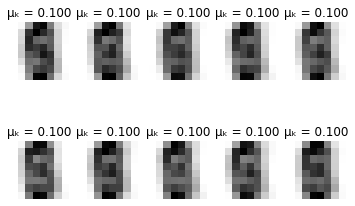

-------- iteration 10 --------
Δμₖ: 0.0005060383827942827
Δσₖ: 0.00040090351471860214


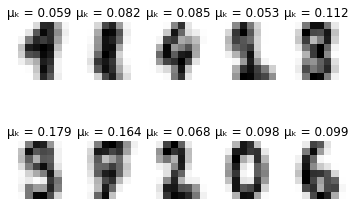

-------- iteration 20 --------
Δμₖ: 0.00010711849331196399
Δσₖ: 7.663011409525522e-05


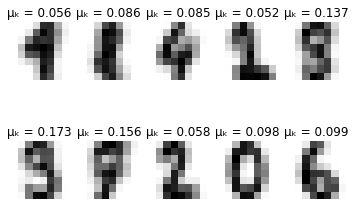

-------- iteration 30 --------
Δμₖ: 3.275392653867559e-05
Δσₖ: 2.008519777491058e-05


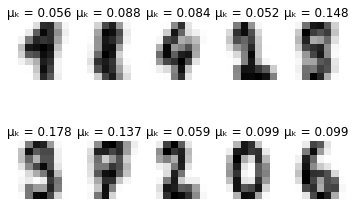

-------- iteration 40 --------
Δμₖ: 0.00025846243592364537
Δσₖ: 0.0001643142181535634


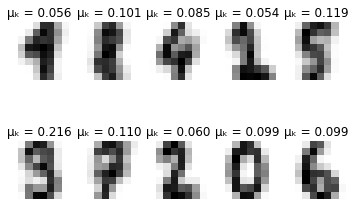

-------- iteration 50 --------
Δμₖ: 0.00010536041983000288
Δσₖ: 6.277350383704361e-05


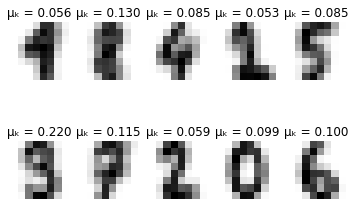

-------- converged--------


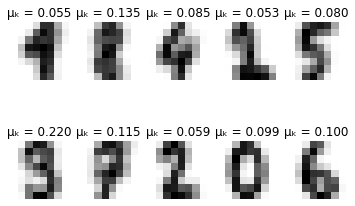

In [ ]:
model.fit(train_features)

#### Visualising the model results

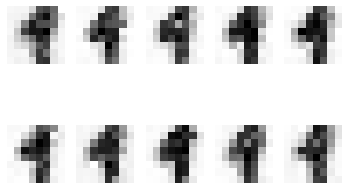

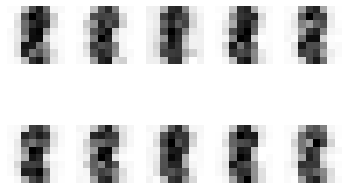

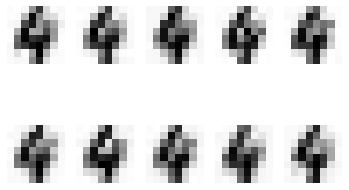

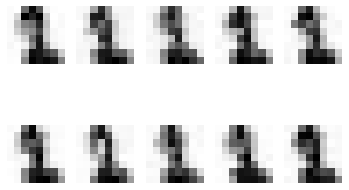

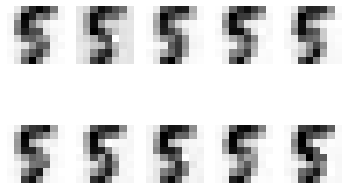

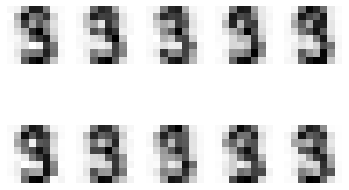

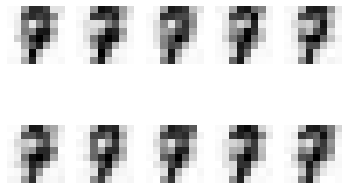

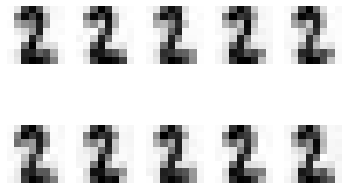

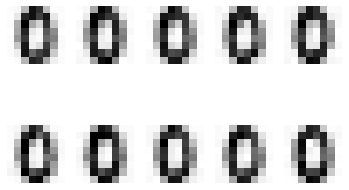

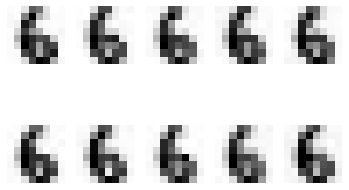

In [ ]:
# Generating digits using learnt distributions
for i in range(10):
    for j in range(10):
        pixels = np.array([np.random.normal(model.means_[i][pixel], model.covariances_[i][pixel]) for pixel in range(64)])
        plt.subplot(2, 5, j + 1)
        plt.axis('off')
        plt.imshow(pixels.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

#### Clustering training data

*2. Use the results of the EM-algorithm (the found distribution parameters) to cluster the training data (esentially, using the resulting classifier to do a prediction over the training data). Produce a confusion matrix over the known labels for the training data and your EM-generated clusters. What do you see?*

In [ ]:
class GNB:
    def __init__(self, gmm):
        self.gmm = gmm
        
    def fit(self, K):
        self.K = K     
        self.means = self.gmm.means_
        self.covs = self.gmm.covariances_
        self.weights = np.log(self.gmm.weights_)

    def predict_single(self, x):
        f = lambda i: self.weights[i] + multivariate_normal.logpdf(x, mean=self.means[i], cov=self.covs[i])        
        return np.argmax(
            np.fromfunction(np.vectorize(f), shape=(self.K,), dtype=int)
        )
    
    def predict(self, X, translate_targets=True):
        y_pred = np.apply_along_axis(self.predict_single, axis=1, arr=X)
        return y_pred

In [ ]:
gnb = GNB(model)

In [ ]:
gnb.fit(K)

In [ ]:
y_pred = gnb.predict(train_features)

In [ ]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.37      0.49      0.42       129
           2       0.00      0.00      0.00       124
           3       0.03      0.02      0.02       130
           4       0.01      0.01      0.01       124
           5       0.10      0.23      0.14       126
           6       0.00      0.00      0.00       127
           7       0.00      0.00      0.00       125
           8       0.00      0.00      0.00       122
           9       0.00      0.00      0.00       125

    accuracy                           0.08      1257
   macro avg       0.05      0.07      0.06      1257
weighted avg       0.05      0.08      0.06      1257

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f472a2648d0>)

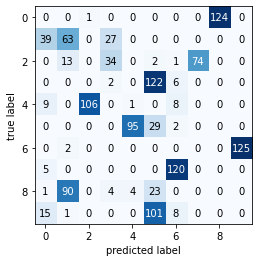

In [ ]:
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(train_labels, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(train_labels, y_pred))

In [ ]:
print("Accuracy: %s" %(metrics.accuracy_score(train_labels, y_pred)))
print("Completeness score: %s" %(metrics.completeness_score(train_labels, y_pred)))
print("Homogeneity score: %s" %(metrics.homogeneity_score(train_labels, y_pred)))
print("AMI score: %s" %(metrics.adjusted_mutual_info_score(train_labels, y_pred)))

Accuracy: 0.07557677008750995
Completeness score: 0.7642499093855386
Homogeneity score: 0.7314664403825363
AMI score: 0.7437553726604315


#### Repairing cluster assignments

*3.   If necessary, find a way to "repair" the cluster assignments so that you can do a prediction run over the test data, from which you can compare the results with your earlier implementation of the Gaussian NBC.*

##### Method 1. Reassign class labels manually

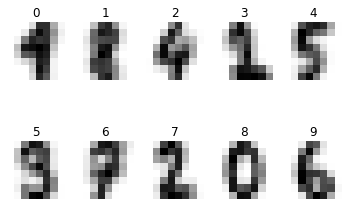

In [ ]:
# Visualise cluster assignments
fig = plt.figure()
for k in range(K):
    img = np.reshape(gnb.means[k], (8,8))
    plt.subplot(2, 5, k + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(str(k))
plt.show()

In [ ]:
# "Repair" training set predictions
y_train = np.zeros(len(y_pred))
y_train[y_pred == 0] = 9
y_train[y_pred == 1] = 8
y_train[y_pred == 2] = 4
y_train[y_pred == 3] = 1
y_train[y_pred == 4] = 5
y_train[y_pred == 5] = 3
y_train[y_pred == 6] = 7
y_train[y_pred == 7] = 2
y_train[y_pred == 8] = 0
y_train[y_pred == 9] = 6

Repaired training set cluster assignments...
----------Classification Report-----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       125
           1       0.40      0.21      0.28       129
           2       1.00      0.60      0.75       124
           3       0.44      0.94      0.60       130
           4       0.99      0.85      0.92       124
           5       0.95      0.75      0.84       126
           6       1.00      0.98      0.99       127
           7       0.83      0.96      0.89       125
           8       0.53      0.74      0.62       122
           9       0.22      0.12      0.15       125

    accuracy                           0.71      1257
   macro avg       0.74      0.71      0.70      1257
weighted avg       0.73      0.71      0.70      1257

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f47297bca10>)

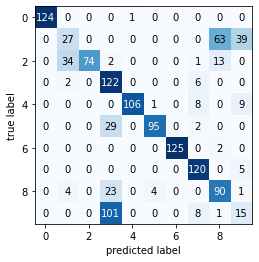

In [ ]:
print('Repaired training set cluster assignments...')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(train_labels, y_train))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(train_labels, y_train))

The downside to this approach is that we have to manually alter the assigned class labels for both the train and test set predictions.

##### Method 2. Create target mapping function

In [ ]:
class GNB:
    def __init__(self, gmm):
        self.gmm = gmm
        
    def fit(self, K, X_train, y_train):
        self.K = K
        self.means = self.gmm.means_
        self.covs = self.gmm.covariances_
        self.weights = np.log(self.gmm.weights_)          
        self.create_target_mapping(X_train, y_train)
        
    def create_target_mapping(self, X_train, y_train):
        self.target_mapping = np.zeros(self.K)
        y_pred = self.predict(X_train, translate_targets=False)
        for i in range(self.K):
            indexes = y_pred == i
            self.target_mapping[i] = mode(y_train[indexes])[0][0]
    
    def predict_single(self, x):
        f = lambda i: self.weights[i] + multivariate_normal.logpdf(x, mean=self.means[i], cov=self.covs[i]) 
        return np.argmax(
            np.fromfunction(np.vectorize(f), shape=(self.K,), dtype=int)
        )
    
    def predict(self, X_test, translate_targets=True):
        y = np.apply_along_axis(self.predict_single, axis=1, arr=X_test)
        return self.target_mapping[y] if translate_targets else y

In [ ]:
# Prediction run over training data

In [ ]:
gnb = GNB(model)

In [ ]:
gnb.fit(K, train_features, train_labels)

In [ ]:
y_pred = gnb.predict(train_features, translate_targets=True)

Prediction over training data...
----------Classification Report-----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       125
           1       0.57      0.30      0.39       129
           2       0.77      0.87      0.82       124
           3       0.44      0.94      0.60       130
           4       0.99      0.85      0.92       124
           5       0.95      0.75      0.84       126
           6       1.00      0.98      0.99       127
           7       0.83      0.96      0.89       125
           8       0.53      0.74      0.62       122
           9       0.00      0.00      0.00       125

    accuracy                           0.74      1257
   macro avg       0.71      0.74      0.71      1257
weighted avg       0.71      0.74      0.71      1257

----------Confusion Matrix----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4729069dd0>)

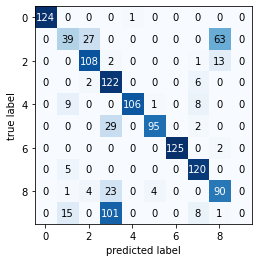

In [ ]:
print('Prediction over training data...')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(train_labels, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(train_labels, y_pred))

In [ ]:
# Prediction run over test data

In [ ]:
y_pred = gnb.predict(test_features, translate_targets=True)

Prediction over test data...
----------Classification Report-----
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        53
           1       0.71      0.32      0.44        53
           2       0.96      0.91      0.93        53
           3       0.34      0.77      0.47        53
           4       0.96      0.89      0.93        57
           5       0.88      0.62      0.73        56
           6       0.98      0.96      0.97        54
           7       0.82      0.98      0.89        54
           8       0.46      0.75      0.57        52
           9       0.00      0.00      0.00        55

    accuracy                           0.71       540
   macro avg       0.71      0.72      0.69       540
weighted avg       0.71      0.71      0.69       540

----------Confusion Matrix----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4728eae910>)

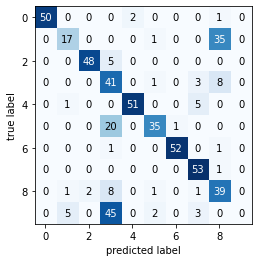

In [ ]:
print('Prediction over test data...')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(test_labels, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(test_labels, y_pred))

### Compare to k-Means with SciKitLearn

*4.   Use now also the k-Means implementation from SciKitLearn and compare the results to yours (they should be similar at least in the sense that there are classes that are more clearly separated from the rest than others for best approaches).*

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
clf = KMeans(n_clusters=len(np.unique(train_labels)), init='random')

In [ ]:
clf.fit(train_features, train_labels)

KMeans(init='random', n_clusters=10)

In [ ]:
# Compute the clusters
y_pred = clf.fit_predict(test_features)

"Because k-means knows nothing about the identity of the cluster, the 0-9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them" – J. VanderPlas, 2016.

In [ ]:
# Permute the labels
labels = np.zeros_like(y_pred)
for i in range(10):
    mask = (y_pred == i)
    labels[mask] = mode(test_labels[mask])[0]

In [ ]:
mat = metrics.confusion_matrix(test_labels, labels)

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.55      1.00      0.71        53
           2       1.00      0.74      0.85        53
           3       0.00      0.00      0.00        53
           4       0.98      0.93      0.95        57
           5       0.91      0.95      0.93        56
           6       0.95      1.00      0.97        54
           7       0.69      1.00      0.82        54
           8       0.00      0.00      0.00        52
           9       0.43      0.82      0.56        55

    accuracy                           0.74       540
   macro avg       0.65      0.74      0.68       540
weighted avg       0.65      0.74      0.68       540

----------Confusion Matrix----------


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

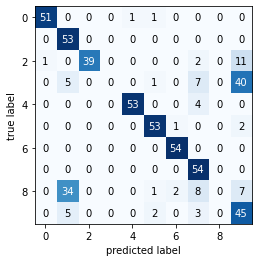

In [ ]:
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(test_labels, labels))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(test_labels, labels))

In [ ]:
print("Accuracy: %s" %(metrics.accuracy_score(test_labels, labels)))
print("Completeness score: %s" %(metrics.completeness_score(test_labels, labels)))
print("Homogeneity score: %s" %(metrics.homogeneity_score(test_labels, labels)))
print("AMI score: %s" %(metrics.adjusted_mutual_info_score(test_labels, labels)))

Accuracy: 0.7444444444444445
Completeness score: 0.8089661544736777
Homogeneity score: 0.7128614631464921
AMI score: 0.7508813410219344


Some hints on the quality of your EM result: It is, in principle with a vanilla implementation as given above, possible to achieve a completeness score (`sklearn.metrics.completeness_score`) of approximately `0.72`, where the respective score for the k-Means clustering is `~0.77` on the `digits` data. Alternatively, you can use the homogenity score, (`sklearn.metrics.homogenity_score`), which I got to `~0.71` (k-Means: `0.74`), or the adjusted mutual information score (`~0.71`, k-Means: `0.74`). Take these numbers as some hint, not as the ultimate truth, please, but they should give you some idea of what is possible.

## Credits
This assignment was prepared by E.A Topp et al., HT2019 (link [here](https://web.archive.org/web/20200111075148/http://cs.lth.se/edan95/lab-programming-assignments/lab-session-6/)).

Label permutation problem for k-Means clustering of digits dataset explained in detail [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).